# Wie beschleunige ich meine Datenanalyse zuhause oder im Cluster

## Parallelisierung der Merkmalsberechnung mit python, joblib und dask

Zuerst initialisieren wir unsere Umgebung mit einigen Paketen. Falls es zu Fehlern kommt sollten die Pakete auf der Kommandozeile mit pip oder conda nachinstalliert werden.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import time
import numpy as np
import sklearn as sk
from tqdm import tqdm
import dask.dataframe as dd
import intake
from dtreeviz.trees import *

%matplotlib inline
%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"

Die folgenden Pfade müssen angepasst werden, sobald die Daten runtergeladen wurden (>800MB gepackt). Die Daten können unter https://bwsyncandshare.kit.edu/s/NzrXCAnTHDWJZRk heruntergeladen werden.

In [2]:
TRAIN_LABEL_PATH = "data/train_labels.csv"
TRAIN_PATH = "data/train/"

'/smartdata/proj_sdsc_TMP/windrad/data/train/'

![windrad](images/data.PNG)

Die Daten sind von verschiedene Windrädern in China bei denen 75 Sensoren alle 10 Minuten aufgezeichnet wurden.

In [3]:
data= pd.read_csv("data/train/002/cbd192c9-5e59-3b3c-bae8-20f8ae9f2b36.csv")

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,...,blade 3 inverter box temperature,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque
0,14.63,154.01,0.24,0.31,0.22,12.48,13.58,14.00,14.91,2.6,...,300,0,0,0,0,0,0,0,0,0
1,13.74,312.77,0.24,0.31,0.22,11.36,11.14,13.06,13.95,8.7,...,300,0,0,0,0,0,0,0,0,0
2,13.55,73.76,0.24,0.31,0.22,11.74,11.90,14.64,13.81,5.4,...,300,0,0,0,0,0,0,0,0,0
3,12.21,132.26,0.24,0.31,0.22,10.08,10.30,12.20,12.47,-7.1,...,300,0,0,0,0,0,0,0,0,0
4,12.91,239.51,0.24,0.31,0.22,10.90,11.84,13.04,13.16,1.2,...,300,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,11.37,93.24,0.24,0.31,0.22,10.10,8.84,11.28,11.62,-27.1,...,300,0,0,0,0,0,0,0,0,0
446,14.37,194.51,0.24,0.31,0.22,12.20,13.46,14.64,14.65,1.6,...,300,0,0,0,0,0,0,0,0,0
447,12.31,82.76,0.24,0.31,0.22,10.00,10.10,12.02,12.60,-1.5,...,300,0,0,0,0,0,0,0,0,0
448,12.24,183.49,0.24,0.31,0.22,9.48,10.30,11.56,12.50,2.3,...,300,0,0,0,0,0,0,0,0,0


Soviele Minuten umfasst die Datei:

In [4]:
data.shape[0]*10

4500

Die Spalten sind Zeitreihen

<AxesSubplot:>

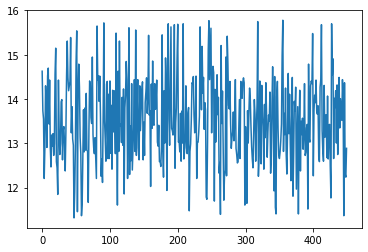

In [5]:
data["Wheel speed"].plot()

Zu jeder multidimensionalen Zeitreihe gehört ein Label: 1 wenn das Windrad danach einen Defekt hatte, ansonsten 0.  Die Herausforderung wird es sein den Defekt anhand der Zeitreihe vorherzusagen.

In [14]:
label=pd.read_csv(TRAIN_LABEL_PATH)

,f_id,file_name,ret
0,95,dba63ee5-6603-300e-8071-8536afcbc2de.csv,0
1,95,0b8bfa51-cf28-35d0-94d2-7922f45120b2.csv,0
2,95,d7a64eee-165e-3d39-be67-adc82050bde3.csv,0
3,95,4da3314d-c5b0-3782-bdd6-27fb9e251261.csv,0
4,95,7d58a65f-af5a-3433-bcbb-a342b9468b71.csv,0
...,...,...,...
48334,11,d6e19de9-22a8-39e6-98c1-cc599c819a56.csv,1
48335,11,83895667-dc4e-303a-90e7-7dfc0725f476.csv,1
48336,11,a6ab9f83-4bea-323f-b08e-4a9fb4eab8d6.csv,1
48337,11,a19af894-a9c8-3127-87e4-39567f0a9e0c.csv,1


Die Label sind bereits balanciert, was das Vorhersageproblem später einfacher macht. 

<AxesSubplot:>

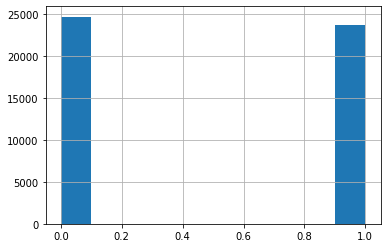

In [17]:
label["ret"].hist()

Um eine einfache Klassifikation auf das Label zu machen können Merkmale auf den Zeitreihen berechnet werden um kritische Ausprägungen mit einen Klassifikationsalgorithmus zu lernen. Das Schweizer Taschenmesser der Merkmalsextraktion ist https://github.com/blue-yonder/tsfresh der Karlsruher Firma BlueYonder

In [19]:
%%timeit -r1 -n1 -o
import tsfresh
data["id"]="a"
tsfresh.extract_features(data,n_jobs=1,column_id="id")

Feature Extraction: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


24.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 24.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

Wenn man nun alle Dateien auf einer CPU Laden will so dauert das dann ca. so viele Stunden:

In [20]:
label.shape[0]*_.average/60/60

328.147238520002

Zum Glück unterstützt tsfresh bereits Parallelisierung:Probieren Sie verschiedene Werte für n_jobs aus. Sie werden merken, dass die Parallelisierung nicht ganz linear skaliert

Um die Liste aller Dateien zu bekommen, müssen wir übrigens noch den Pfad dran hängen und den Ordner dreistellig kodieren

In [22]:
files=label.apply(lambda row: TRAIN_PATH+"{:03d}/{}".format(row["f_id"],row["file_name"]),axis=1)

0        /smartdata/proj_sdsc_TMP/windrad/data/train/09...
1        /smartdata/proj_sdsc_TMP/windrad/data/train/09...
2        /smartdata/proj_sdsc_TMP/windrad/data/train/09...
3        /smartdata/proj_sdsc_TMP/windrad/data/train/09...
4        /smartdata/proj_sdsc_TMP/windrad/data/train/09...
                               ...                        
48334    /smartdata/proj_sdsc_TMP/windrad/data/train/01...
48335    /smartdata/proj_sdsc_TMP/windrad/data/train/01...
48336    /smartdata/proj_sdsc_TMP/windrad/data/train/01...
48337    /smartdata/proj_sdsc_TMP/windrad/data/train/01...
48338    /smartdata/proj_sdsc_TMP/windrad/data/train/01...
Length: 48339, dtype: object

Die Daten einfach alle in den Speicher zu laden funktioniert übrigens auch nicht. Insgesamt sprechen wir über soviele Gigabyte:

In [31]:
from pathlib import Path
sum(Path(f).stat().st_size  for f in files) /(1024**3)

6.261525361798704

Nun kopieren wir die Teile von oben in eine Funktion um sie auf alle Dateien anzuwenden

In [33]:
def get_features(file):
    data= pd.read_csv(file)
    data["id"]=file
    return tsfresh.extract_features(data,disable_progressbar=True, n_jobs=1,column_id="id")

Damit es schneller geht können wir ein paar einfachere Features verwenden

In [35]:
def get_features(file):
    data= pd.read_csv(file)
    data["id"]=file
    return data.groupby("id").agg(["mean","max","min"])

Wir iterieren hierzu über alle Files und stecken Sie in einen Dataframe (zu Demozwecken nur die ersten 100). tqdm ist für die Statusanzeige zuständig

In [37]:
%%time
features=pd.concat(get_features(f) for f in tqdm(files[0:100]))

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


CPU times: user 21.8 s, sys: 57.2 ms, total: 21.9 s
Wall time: 23.4 s


Python unterstützt von Haus aus nur einen Prozessor. Hier nutzen wir also nicht unseren Prozesser aus. Hierzu gibt es die joblib. Mit delayed werden die Berechnungen asyncron gestartet. Wenn man mehrere Prozessorkerne hat wird man durch die Erhöhung von n_jobs wie schon oben eine leichte Beschleunigung feststellen (Engpass ist meist die Festplatte).

In [38]:
%%time
from joblib import Parallel, delayed
features=pd.concat(Parallel(n_jobs=4)(delayed(get_features)(f) for f in tqdm(files[0:100])))

100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


CPU times: user 6.9 s, sys: 186 ms, total: 7.09 s
Wall time: 17.7 s


Limitierend sind hier auch die CPUs und der RAM in einem Rechner. Sehr große Rechner sind meist extrem teuer. Billiger geht es im Cluster.  (HTCondor)[https://research.cs.wisc.edu/htcondor/] ist ein Clusterscheduler der von der Python Bibliothek (dask)[https://dask.org/] für verteiltes Rechnen unterstützt wird. Damit wird die Erstellung eines eigenen Clusters in einem Hochleistungs-Cluster einfach. Aber man kann hier auch viele Rechner im Firmennetzwerk zusammenschalten. (Geht auch über Kubernetes oder Yarn in der Cloud). Wir holen uns nun ein paar Rechner mit 8 Prozessorkernen und je 32GB RAM und ner kleinen Festplatte (wir wollen die Daten nur in den Speicher laden).

In [39]:
from dask_jobqueue import HTCondorCluster
from distributed import Client

os.environ["_condor_SCHEDD_HOST"]="login-l.sdil.kit.edu"
cluster= HTCondorCluster(cores=8, memory= "32GB", disk="400MB")
client=Client(cluster)
cluster

Diese Konfiguration können wir nun in unserem Fall beliebig hochskalieren.

In [41]:
cluster.scale(32)

Unser Beispiel von oben lässt sich trivial beschleunigen. Wenn sie das Pythonpaket bokeh installiert haben können sie auf dem Dashboard (link oben) sehen wie die Funktion parallel auf dem Cluster ausgeführt wird. (Die Statusbar ist hier unsinnig, da alle jobs parallel in den Cluster geschickt werden)

In [43]:
%%time
from joblib import parallel_backend
with parallel_backend('dask'):
    features=pd.concat(Parallel()(delayed(get_features)(f) for f in tqdm(files[0:100])))

100%|██████████| 100/100 [00:00<00:00, 11782.08it/s]


CPU times: user 7.41 s, sys: 201 ms, total: 7.61 s
Wall time: 7.65 s


Es geht aber noch einfacher. Die  Idee von Big Data ist es das Berechnungsgraphen auf großen verteilten Datenquellen ausgeführt werden. Wir nutzen hier das Paket [intake](https://github.com/intake/intake/) um die Datenquelle verteilt in dask zu laden.

In [45]:
ddf=intake.open_csv(TRAIN_PATH+"006/02{file_name}.csv").to_dask()

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,x direction vibration value,y direction vibration value,hydraulic brake pressure,Aircraft weather station wind speed,wind direction absolute value,atmospheric pressure,reactive power control status,inverter grid side current,inverter grid side voltage,Inverter grid side active power,inverter grid side reactive power,inverter generator side power,generator operating frequency,generator current,generator torque,Inverter inlet temperature,inverter outlet temperature,inverter inlet pressure,inverter outlet pressure,generator power limit value,reactive power set value,Rated hub speed,wind tower ambient temperature,generator stator temperature 1,generator stator temperature 2,generator stator temperature 3,generator stator temperature 4,Generator stator temperature 5,generator stator temperature 6,generator air temperature 1,generator air temperature 2,main bearing temperature 1,main bearing temperature 2,Wheel temperature,Wheel control cabinet temperature,Cabin temperature,Cabin control cabinet temperature,Inverter INU temperature,Inverter ISU temperature,Inverter INU RMIO temperature,Pitch motor 1 power estimation,Pitch motor 2 power estimation,Pitch motor 3 power estimation,Fan current status value,hub current status value,yaw state value,yaw request value,blade 1 battery box temperature,blade 2 battery box temperature,blade 3 battery box temperature,vane 1 pitch motor temperature,blade 2 pitch motor temperature,blade 3 pitch motor temperature,blade 1 inverter box temperature,blade 2 inverter box temperature,blade 3 inverter box temperature,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque,file_name
npartitions=9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Wir haben erstmal eine kleine Anzahl von Dateien geladen. Dask macht im Hintergrund allerdings nichts als automatisch eine Datenstruktur anzulegen. Wir können aber z.B. sehr schnell die ersten Daten anschauen (liest nur einen kleinen Auschnitt einer einzigen Datei).

In [46]:
ddf.head()

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,...,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque,file_name
0,1.77,339.01,21.0,21.01,21.0,1.88,2.64,1.76,1.78,-18.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393eca-db4c-39a5-abd9-569ead6e26a7
1,1.82,123.01,21.0,21.01,21.0,1.10,2.54,1.58,1.82,-14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393eca-db4c-39a5-abd9-569ead6e26a7
2,1.82,230.00,21.0,21.01,21.0,1.56,2.70,1.40,1.82,1.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393eca-db4c-39a5-abd9-569ead6e26a7
3,1.73,33.98,21.0,21.01,21.0,0.80,2.70,0.86,1.74,-12.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393eca-db4c-39a5-abd9-569ead6e26a7
4,1.75,82.01,21.0,21.01,21.0,1.64,2.70,1.82,1.78,-14.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393eca-db4c-39a5-abd9-569ead6e26a7


Genauso können wir unsere Merkmalsextraktion wie oben spezifizieren. Hier brauchen wir jetzt nicht mehr die Daten in jeder Funktion einzulesen

In [48]:
dfeatures=ddf.groupby(['file_name']).agg(["mean","var","min","max"])

Dask DataFrame Structure:
              Wheel speed                            hub angle                            blade 1 angle                            blade 2 angle                            blade 3 angle                            pitch motor 1 current                            pitch motor 2 current                            Pitch motor 3 current                            overspeed sensor speed detection value                            5 second yaw against wind average                            x direction vibration value                            y direction vibration value                            hydraulic brake pressure                            Aircraft weather station wind speed                            wind direction absolute value                            atmospheric pressure                            reactive power control status                            inverter grid side current                            inverter grid side voltage                            Inverter grid side active power                            inverter grid side reactive power                            inverter generator side power                            generator operating frequency                            generator current                            generator torque                            Inverter inlet temperature                            inverter outlet temperature                            inverter inlet pressure                            inverter outlet pressure                            generator power limit value                            reactive power set value                            Rated hub speed                            wind tower ambient temperature                            generator stator temperature 1                            generator stator temperature 2                            generator stator temperature 3                            generator stator temperature 4                            Generator stator temperature 5                            generator stator temperature 6                            generator air temperature 1                            generator air temperature 2                            main bearing temperature 1                            main bearing temperature 2                            Wheel temperature                            Wheel control cabinet temperature                            Cabin temperature                            Cabin control cabinet temperature                            Inverter INU temperature                            Inverter ISU temperature                            Inverter INU RMIO temperature                            Pitch motor 1 power estimation                            Pitch motor 2 power estimation                            Pitch motor 3 power estimation                            Fan current status value                            hub current status value                            yaw state value                            yaw request value                            blade 1 battery box temperature                            blade 2 battery box temperature                            blade 3 battery box temperature                            vane 1 pitch motor temperature                            blade 2 pitch motor temperature                            blade 3 pitch motor temperature                            blade 1 inverter box temperature                            blade 2 inverter box temperature                            blade 3 inverter box temperature                            blade 1 super capacitor voltage                            blade 2 super capacitor voltage                            blade 3 super capacitor voltage                            drive 1 thyristor temperature                            Drive 2 thyristor temperature                            Drive 3 thyristor temperature                            Drive 1 output torque                            Drive 2 output

Wieder ist kaum was im Hintergrund passiert. Dask hat hier einen Berechnungsgraphen aufgebaut und die Datenstruktur für das Resultat angelegt.

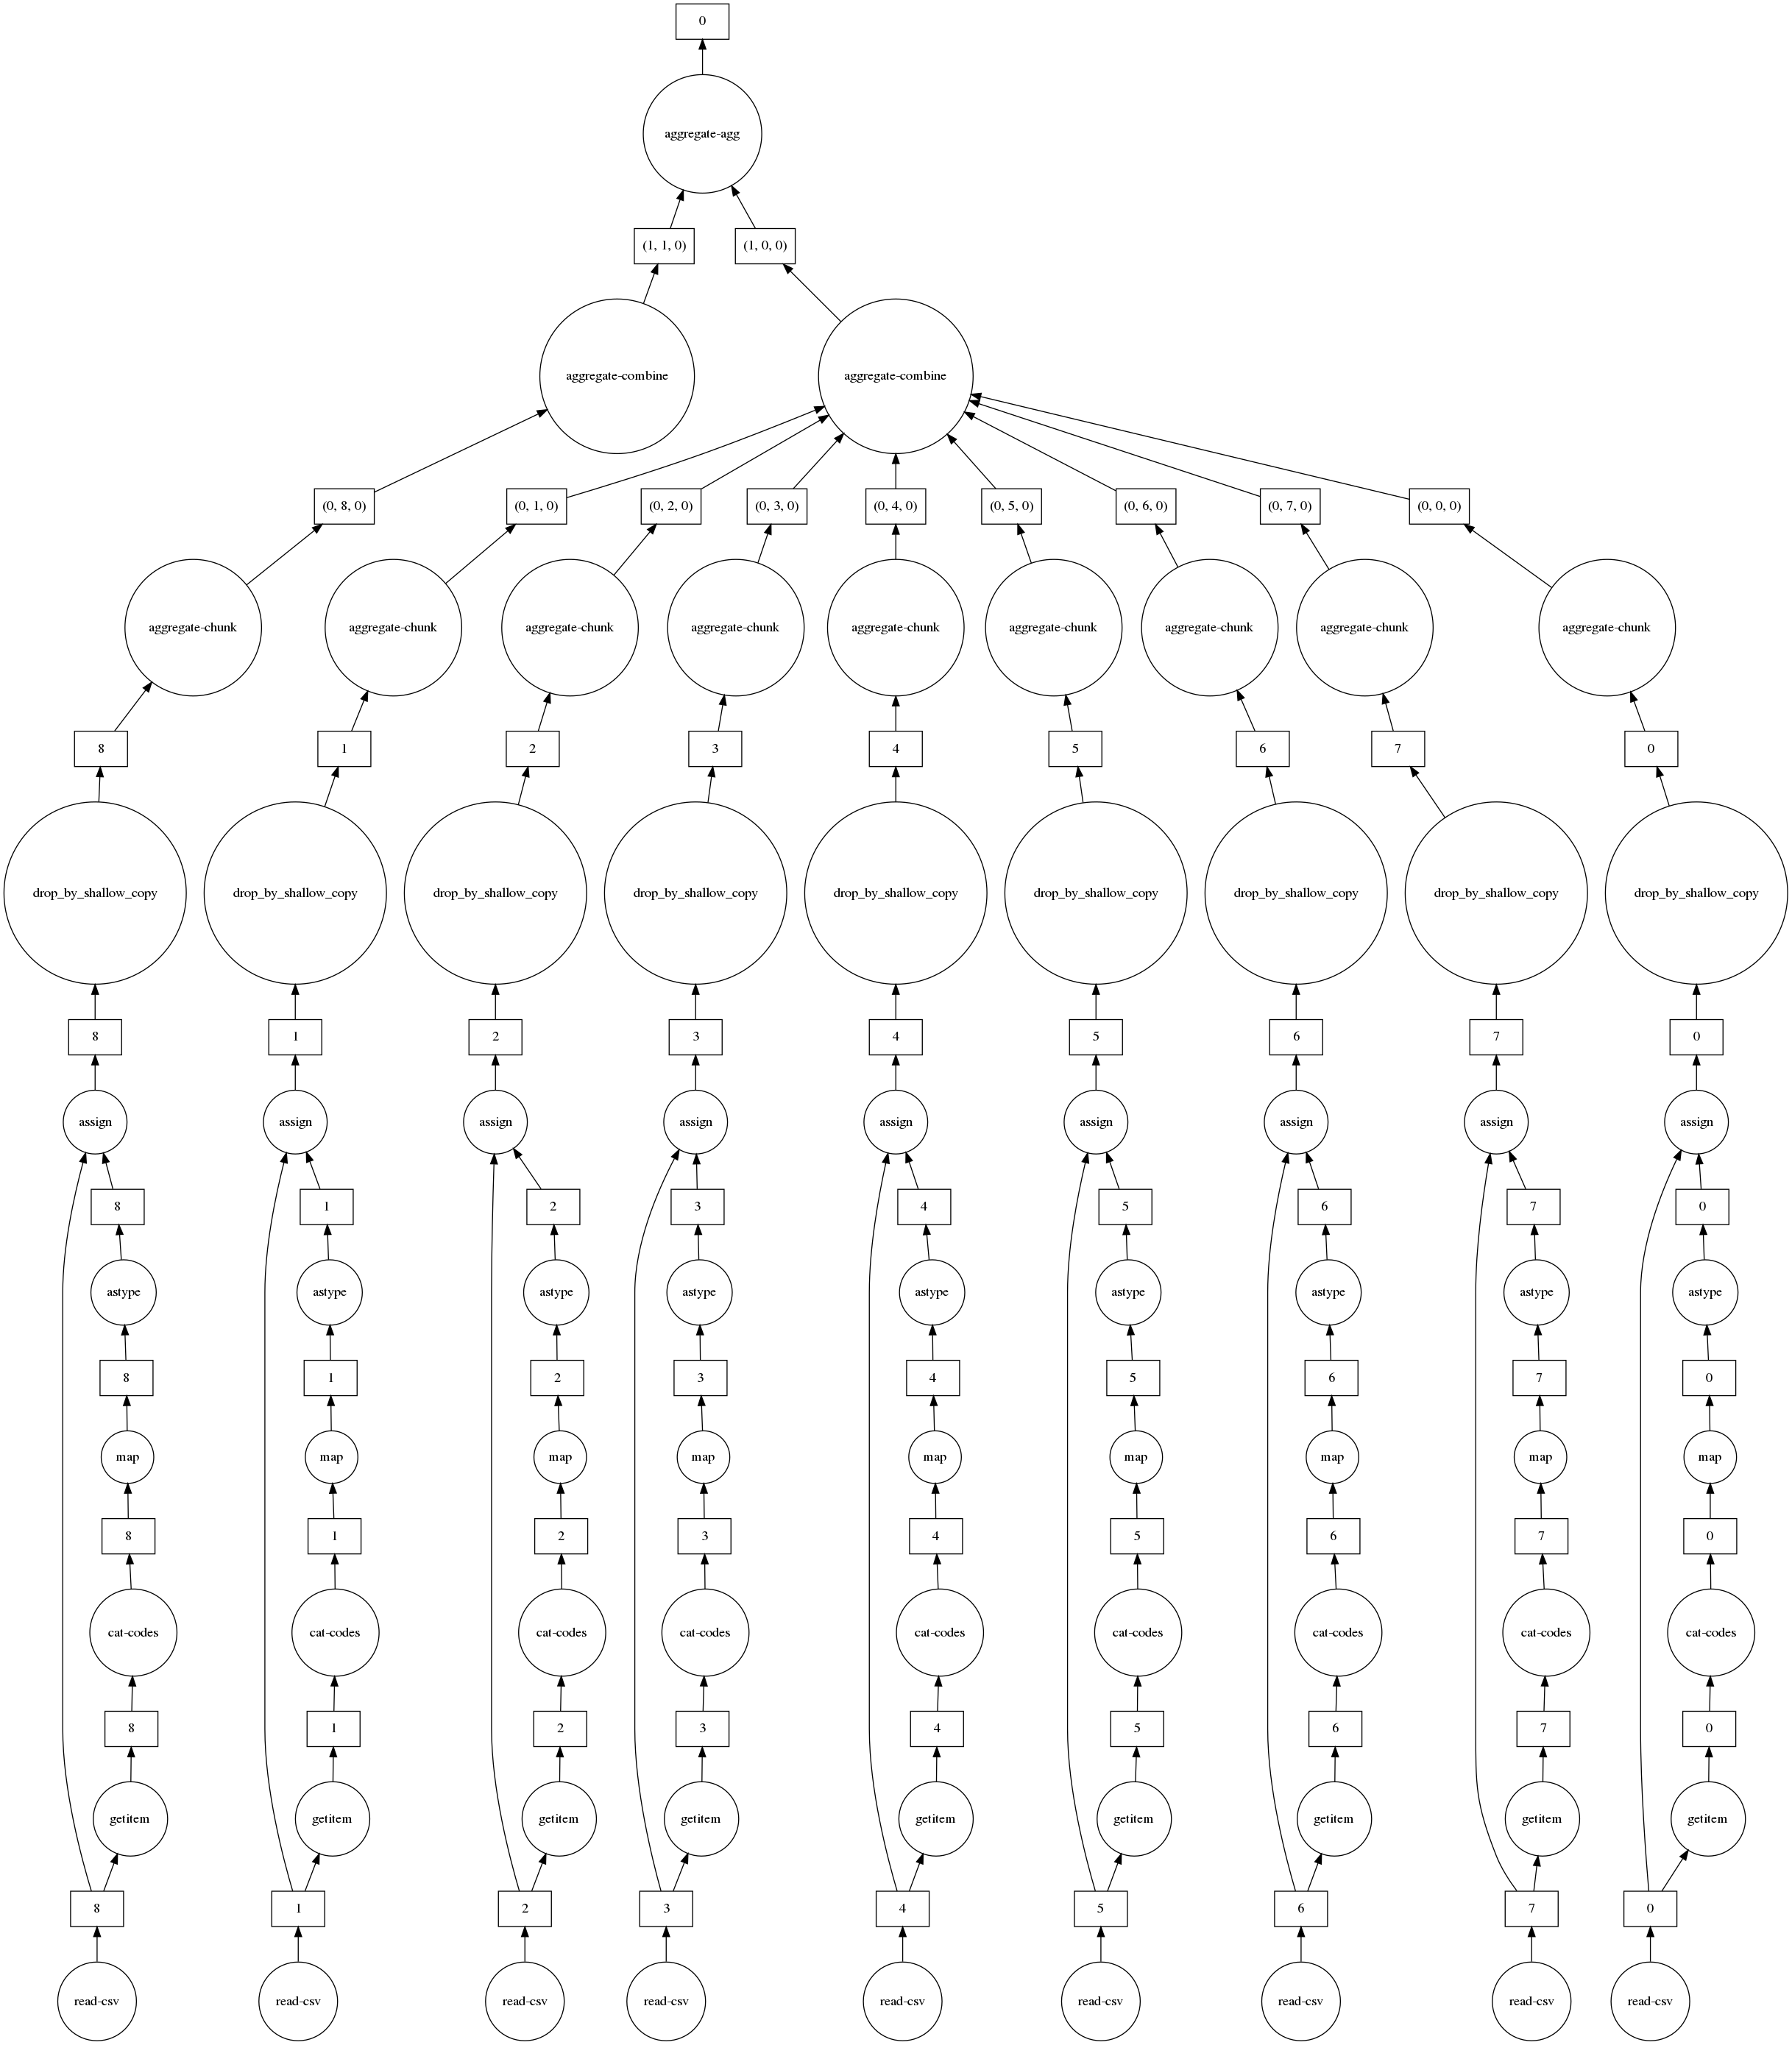

In [49]:
dfeatures.visualize()

Um die Berechnung zu demonstrieren wagen wir uns an etwas mehr Daten (Der Graph wird dann etwas zu groß um ihn noch im Notebook darzustellen, sonst ist alles gleich)

In [50]:
ddf=intake.open_csv(TRAIN_PATH+"006/{file_name}.csv").to_dask()
dfeatures=ddf.groupby(['file_name']).agg(["mean","var","min","max"])

Dask DataFrame Structure:
              Wheel speed                            hub angle                            blade 1 angle                            blade 2 angle                            blade 3 angle                            pitch motor 1 current                            pitch motor 2 current                            Pitch motor 3 current                            overspeed sensor speed detection value                            5 second yaw against wind average                            x direction vibration value                            y direction vibration value                            hydraulic brake pressure                            Aircraft weather station wind speed                            wind direction absolute value                            atmospheric pressure                            reactive power control status                            inverter grid side current                            inverter grid side voltage                            Inverter grid side active power                            inverter grid side reactive power                            inverter generator side power                            generator operating frequency                            generator current                            generator torque                            Inverter inlet temperature                            inverter outlet temperature                            inverter inlet pressure                            inverter outlet pressure                            generator power limit value                            reactive power set value                            Rated hub speed                            wind tower ambient temperature                            generator stator temperature 1                            generator stator temperature 2                            generator stator temperature 3                            generator stator temperature 4                            Generator stator temperature 5                            generator stator temperature 6                            generator air temperature 1                            generator air temperature 2                            main bearing temperature 1                            main bearing temperature 2                            Wheel temperature                            Wheel control cabinet temperature                            Cabin temperature                            Cabin control cabinet temperature                            Inverter INU temperature                            Inverter ISU temperature                            Inverter INU RMIO temperature                            Pitch motor 1 power estimation                            Pitch motor 2 power estimation                            Pitch motor 3 power estimation                            Fan current status value                            hub current status value                            yaw state value                            yaw request value                            blade 1 battery box temperature                            blade 2 battery box temperature                            blade 3 battery box temperature                            vane 1 pitch motor temperature                            blade 2 pitch motor temperature                            blade 3 pitch motor temperature                            blade 1 inverter box temperature                            blade 2 inverter box temperature                            blade 3 inverter box temperature                            blade 1 super capacitor voltage                            blade 2 super capacitor voltage                            blade 3 super capacitor voltage                            drive 1 thyristor temperature                            Drive 2 thyristor temperature                            Drive 3 thyristor temperature                            Drive 1 output torque                            Drive 2 output

Die eigentliche Berechnung stoßen wir mit compute an. Jetzt sollte man wieder auf das Cluster dashboard wechseln. Am besten schaut man sich hier den Graph an. Hier kann man sehen wie nach und nach parallel die Daten eingelesen werden und das Ergebnis stückweise aggregiert wird. 

In [51]:
features=dfeatures.compute()

Wheel speed                         \
                                            mean       var   min    max   
file_name                                                                 
666a6cf9-924c-3de9-9ef5-2fbef5ca41b0    7.221927  0.003140  7.08   7.34   
ac9e5e3c-7be8-32e1-a8ed-18b514deb246    7.148732  0.246737  0.00   7.24   
e5ec578b-c5a5-3088-98f4-41264ce17859   15.752705  1.947185  0.00  16.64   
5785bd44-21f4-3585-9b29-ba309115bd2c   12.611022  1.368645  9.30  14.22   
2fe6f0a0-4757-3ae4-b4a0-103493d789cf    0.003147  0.000106 -0.01   0.06   
...                                          ...       ...   ...    ...   
6ce64374-827a-30dd-b5b7-007a1f350ac3    8.777699  0.815149  7.29  10.65   
8bdb9313-a6c3-3cf7-9bbd-950f361bcb74    7.973862  0.413934  0.00   9.03   
7f690922-03a0-3eda-9bde-4314c51e04d5   11.124664  0.795493  0.00  12.35   
3d298e6b-3222-3370-a415-3c62e7112ab8    7.694931  0.220036  0.00   8.67   
3f6796ae-89fe-3a7e-8de1-2f23ba82232e    5.572020  1.401133  0.00   6.64   

                                       hub angle                             \
                                            mean           var  min     max   
file_name                                                                     
666a6cf9-924c-3de9-9ef5-2fbef5ca41b0  176.558617  10629.140008  0.0  357.98   
ac9e5e3c-7be8-32e1-a8ed-18b514deb246  176.455789  11167.986582  0.0  359.75   
e5ec578b-c5a5-3088-98f4-41264ce17859  180.718159  11216.768807  0.0  358.24   
5785bd44-21f4-3585-9b29-ba309115bd2c  179.609667  10539.434344  0.0  359.50   
2fe6f0a0-4757-3ae4-b4a0-103493d789cf  160.508462    139.041954  0.0  165.49   
...                                          ...           ...  ...     ...   
6ce64374-827a-30dd-b5b7-007a1f350ac3  175.320774  11069.534996  0.0  357.98   
8bdb9313-a6c3-3cf7-9bbd-950f361bcb74  180.106920  10816.378567  0.0  360.00   
7f690922-03a0-3eda-9bde-4314c51e04d5  176.797444  10679.227688  0.0  357.98   
3d298e6b-3222-3370-a415-3c62e7112ab8  176.339128  10876.806797  0.0  357.98   
3f6796ae-89fe-3a7e-8de1-2f23ba82232e  174.478384  11259.222959  0.0  360.00   

                                     blade 1 angle              ...  \
                                              mean         var  ...   
file_name                                                       ...   
666a6cf9-924c-3de9-9ef5-2fbef5ca41b0      0.279252    0.000007  ...   
ac9e5e3c-7be8-32e1-a8ed-18b514deb246      0.218947    0.000231  ...   
e5ec578b-c5a5-3088-98f4-41264ce17859      0.381409    0.001831  ...   
5785bd44-21f4-3585-9b29-ba309115bd2c      0.367378    0.000019  ...   
2fe6f0a0-4757-3ae4-b4a0-103493d789cf     85.599068   34.399625  ...   
...                                            ...         ...  ...   
6ce64374-827a-30dd-b5b7-007a1f350ac3      0.246082    0.000024  ...   
8bdb9313-a6c3-3cf7-9bbd-950f361bcb74      0.244152    0.000159  ...   
7f690922-03a0-3eda-9bde-4314c51e04d5      0.219013    0.000217  ...   
3d298e6b-3222-3370-a415-3c62e7112ab8      0.243532    0.000161  ...   
3f6796ae-89fe-3a7e-8de1-2f23ba82232e      2.893502  138.610708  ...   

                                     Drive 1 output torque       \
                                                       min  max   
file_name                                                         
666a6cf9-924c-3de9-9ef5-2fbef5ca41b0                   0.0  0.0   
ac9e5e3c-7be8-32e1-a8ed-18b514deb246                   0.0  0.0   
e5ec578b-c5a5-3088-98f4-41264ce17859                   0.0  0.0   
5785bd44-21f4-3585-9b29-ba309115bd2c                   0.0  0.0   
2fe6f0a0-4757-3ae4-b4a0-103493d789cf                   0.0  0.0   
...                                                    ...  ...   
6ce64374-827a-30dd-b5b7-007a1f350ac3                   0.0  0.0   
8bdb9313-a6c3-3cf7-9bbd-950f361bcb74                   0.0  0.0   
7f690922-03a0-3eda-9bde-4314c51e04d5                   0.0  0.0   
3d298e6b-3222-3370-a415-3c62e7112ab8                   0.0  0.0   
3f6796ae-89fe

Um das Projekt abzuschließen können wir nun mit dem eigentlichen Maschinellen Lernen beginnen. Hierzu fügen wir die labels von oben an den Datensatz an und entfernen die Ids sowie evtl. Nulleinträge.

In [54]:
train=features.join(
    label.set_index(
        label["file_name"].str.replace('.csv','')
    )
).drop(['file_name','f_id'],axis=1).dropna()

,"(Wheel speed, mean)","(Wheel speed, var)","(Wheel speed, min)","(Wheel speed, max)","(hub angle, mean)","(hub angle, var)","(hub angle, min)","(hub angle, max)","(blade 1 angle, mean)","(blade 1 angle, var)",...,"(Drive 1 output torque, max)","(Drive 2 output torque, mean)","(Drive 2 output torque, var)","(Drive 2 output torque, min)","(Drive 2 output torque, max)","(Drive 3 output torque, mean)","(Drive 3 output torque, var)","(Drive 3 output torque, min)","(Drive 3 output torque, max)",ret
file_name,,,,,,,,,,,,,,,,,,,,,
666a6cf9-924c-3de9-9ef5-2fbef5ca41b0,7.221927,0.003140,7.08,7.34,176.558617,10629.140008,0.0,357.98,0.279252,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ac9e5e3c-7be8-32e1-a8ed-18b514deb246,7.148732,0.246737,0.00,7.24,176.455789,11167.986582,0.0,359.75,0.218947,0.000231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
e5ec578b-c5a5-3088-98f4-41264ce17859,15.752705,1.947185,0.00,16.64,180.718159,11216.768807,0.0,358.24,0.381409,0.001831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5785bd44-21f4-3585-9b29-ba309115bd2c,12.611022,1.368645,9.30,14.22,179.609667,10539.434344,0.0,359.50,0.367378,0.000019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2fe6f0a0-4757-3ae4-b4a0-103493d789cf,0.003147,0.000106,-0.01,0.06,160.508462,139.041954,0.0,165.49,85.599068,34.399625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6ce64374-827a-30dd-b5b7-007a1f350ac3,8.777699,0.815149,7.29,10.65,175.320774,11069.534996,0.0,357.98,0.246082,0.000024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8bdb9313-a6c3-3cf7-9bbd-950f361bcb74,7.973862,0.413934,0.00,9.03,180.106920,10816.378567,0.0,360.00,0.244152,0.000159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7f690922-03a0-3eda-9bde-4314c51e04d5,11.124664,0.795493,0.00,12.35,176.797444,10679.227688,0.0,357.98,0.219013,0.000217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Um das Modell zu lernen und später zu überprüfen splitten wir die Daten und Trainings- und Testdaten. 

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( 
    train.drop('ret', axis=1), train["ret"], test_size=0.33, random_state=42)

Nun können wir den Klassifikator lernen.

In [65]:
classifier = sk.ensemble.RandomForestClassifier()

RandomForestClassifier()

Auch wenn wir hier das Cluster zum Parallelisierung nutzen könnten, ist in dem Fall das Lernen so schnell dass es sich kaum lohnt. Hierzu müssten wir alle Daten und viel mehr Merkmale berechnen. Wer hier mehr wissen will sollte https://ml.dask.org/ lesen.

In [66]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

Die Ergebnisse sind übrigens gar nicht mal so schlecht

In [70]:
print(sk.metrics.classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       223
           1       0.94      0.97      0.95       223

    accuracy                           0.95       446
   macro avg       0.95      0.95      0.95       446
weighted avg       0.95      0.95      0.95       446



Wer sich Lust hat anzuschauen, was die verschiedenen Merkmale zur Klassifikation beitragen, kann sich auch noch mal einen Entscheidungbaum anschauen. 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


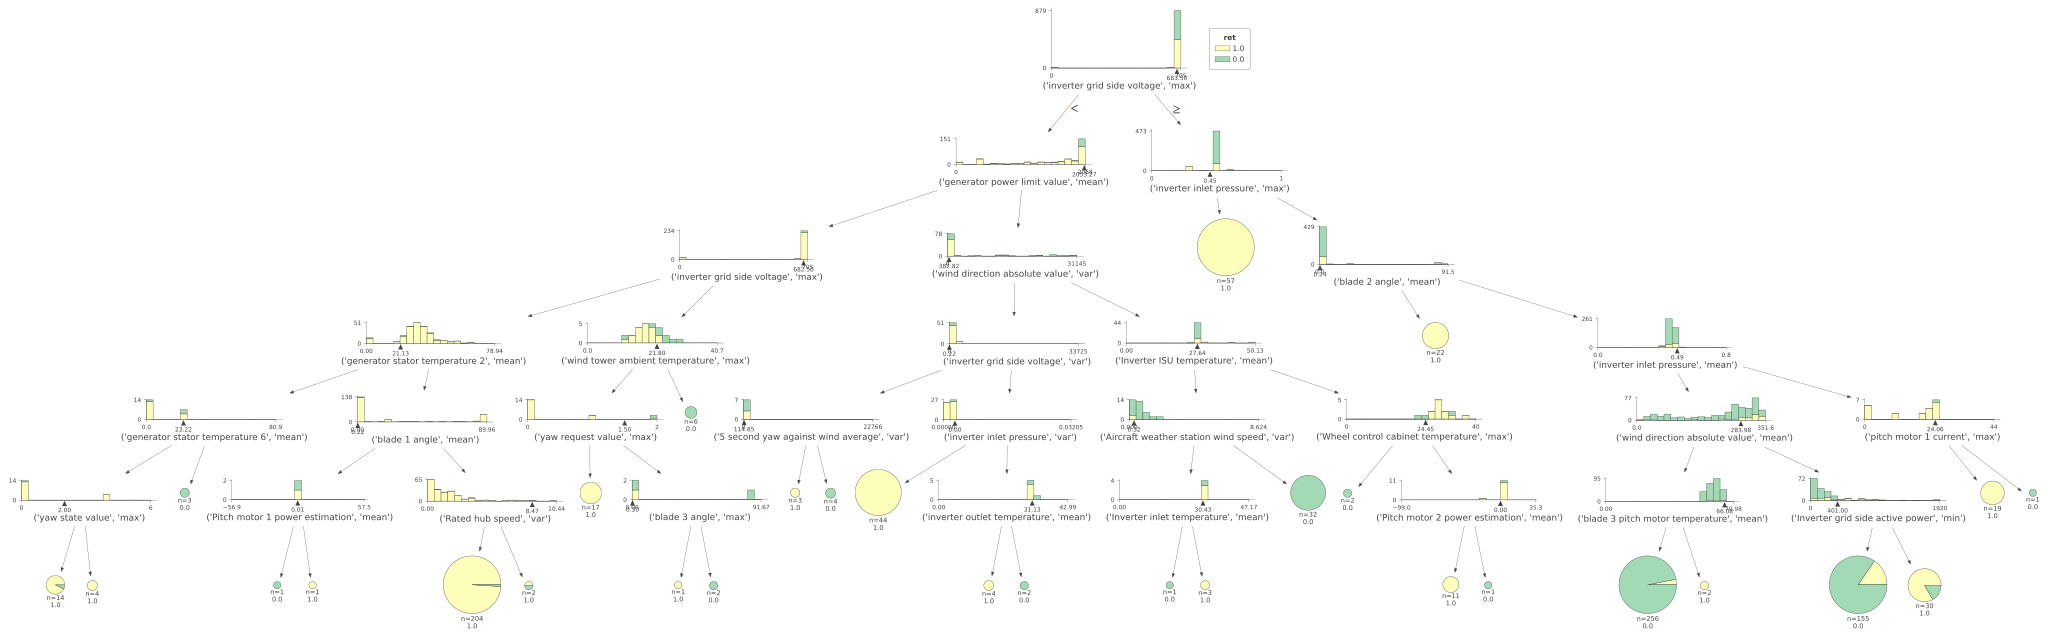

In [71]:
classifier = sk.tree.DecisionTreeClassifier(max_depth=6)  # limit depth of tree

classifier.fit(X_train, y_train)

dtreeviz(classifier, 
               X_train, 
               y_train,
               target_name='ret',
               feature_names=X_train.columns, 
               class_names=["1.0", "0.0"]  # need class_names for classifier
              )  

Am Schluss fahren wir noch unsern Cluster runter, damit andere die CPUs wieder nutzen können :).  

In [72]:
cluster.scale(0)

Das Notebook wurde im Rahmen des [MWK-BW](https://mwk.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/rechenpower-fuer-den-mittelstand-land-unterstuetzt-kleine-und-mittlere-unternehmen-bei-big-data/) geförderten [SDSC-BW Projektes](http://www.sdsc-bw.de) vom KIT TECO entwickelt und kann unter [CC-BY Lizenz](License.md) genutzt und weiterentwickelt werden.